# Importing Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow import feature_column
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Load Data

In [2]:
raw_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1fGJum1PPeKoLv2Eq5w653Nsej0GA-oiE')

In [3]:
raw_data.head(5)

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [4]:
#rename the column name so that there isn't whitespace
raw_data.rename(columns = {'Umur (bulan)':'umur'}, inplace = True)
raw_data.rename(columns = {'Jenis Kelamin':'Jenis_Kelamin'}, inplace = True)
raw_data.rename(columns = {'Tinggi Badan (cm)':'Tinggi_Badan'}, inplace = True)
raw_data.rename(columns = {'Status Gizi':'Status_Gizi'}, inplace = True)

# Assessing Data

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   umur           120999 non-null  int64  
 1   Jenis_Kelamin  120999 non-null  object 
 2   Tinggi_Badan   120999 non-null  float64
 3   Status_Gizi    120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [6]:
raw_data.describe()

,umur,Tinggi_Badan
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [7]:
raw_data["Jenis_Kelamin"].unique()

array(['laki-laki', 'perempuan'], dtype=object)

In [8]:
raw_data.isna().sum()

umur             0
Jenis_Kelamin    0
Tinggi_Badan     0
Status_Gizi      0
dtype: int64

In [9]:
print("Jumlah duplikasi: ", raw_data.duplicated().sum())

Jumlah duplikasi:  81574


In [10]:
raw_data = raw_data.drop_duplicates()

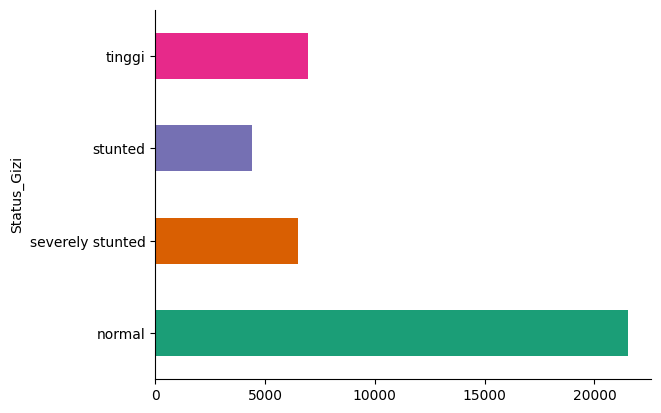

In [11]:
raw_data.groupby('Status_Gizi').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Feature Preparation

Convert the category column to numeric

In [12]:
gender = [0 if kategori == "laki-laki" else 1 for kategori in raw_data["Jenis_Kelamin"]]
raw_data["Jenis_Kelamin"] = gender

In [13]:
category = [0 if kategori == "normal" else 1 if kategori == "tinggi" else 2 if kategori == "stunted" else 3 for kategori in raw_data["Status_Gizi"]]
raw_data["Status_Gizi"] = category

Split data

In [14]:
train, test = train_test_split(raw_data, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

30159 train examples
5323 validation examples
3943 test examples


Handling class imbalance with class weighting

In [15]:
def calculate_class_weights(label_column):
  unique_classes, class_counts = np.unique(label_column, return_counts=True)
  total_samples = len(label_column)
  class_weights = {}

  for class_label, class_count in zip(unique_classes, class_counts):
      class_weight = total_samples / (2.0 * class_count)
      class_weights[class_label] = class_weight

  return class_weights

In [16]:
class_weights = calculate_class_weights(train['Status_Gizi'])

Input pipeline

In [17]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Status_Gizi')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

Choosing feature columns

In [18]:
feature_columns = []
for columns in ['umur', 'Jenis_Kelamin', 'Tinggi_Badan']:
    feature_columns.append(feature_column.numeric_column(columns))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Create a feature layer

In [19]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Modeling

Normalization process

In [21]:
# Variables for normalization
umur_mean = train["umur"].mean()
umur_std = train["umur"].std()
tinggi_badan_mean = train["Tinggi_Badan"].mean()
tinggi_badan_std = train["Tinggi_Badan"].std()

# Initializing the inputs
umur_input = tf.keras.Input(shape=(1,), name='umur')
jenis_kelamin_input = tf.keras.Input(shape=(1,), name='Jenis_Kelamin')
tinggi_badan_input = tf.keras.Input(shape=(1,), name='Tinggi_Badan')

# Normalizing the inputs
normalized_umur = tf.keras.layers.Lambda(lambda x: (x - umur_mean) / umur_std, name='normalize_umur')(umur_input)
normalized_tinggi_badan = tf.keras.layers.Lambda(lambda x: (x - tinggi_badan_mean) / tinggi_badan_std, name='normalize_tinggi_badan')(tinggi_badan_input)

# Combining all the inputs
combined_inputs = tf.keras.layers.Concatenate(name='combine_input')([normalized_umur, jenis_kelamin_input, normalized_tinggi_badan])

Model architecture

In [28]:
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2')(combined_inputs)
x = tf.keras.layers.Dropout(.35)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2')(x)
x = tf.keras.layers.Dropout(.35)(x)
output = tf.keras.layers.Dense(4, activation='softmax', name='output')(x)

model = keras.Model(inputs=[umur_input, jenis_kelamin_input, tinggi_badan_input], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005,
                                              beta_1=0.9,
                                              beta_2=0.999,
                                              amsgrad=True,
                                              use_ema=True,
                                              ema_momentum=0.99),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 umur (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Tinggi_Badan (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 normalize_umur (Lambda)     (None, 1)                    0         ['umur[0][0]']                
                                                                                                  
 Jenis_Kelamin (InputLayer)  [(None, 1)]                  0         []                            
                                                                                            

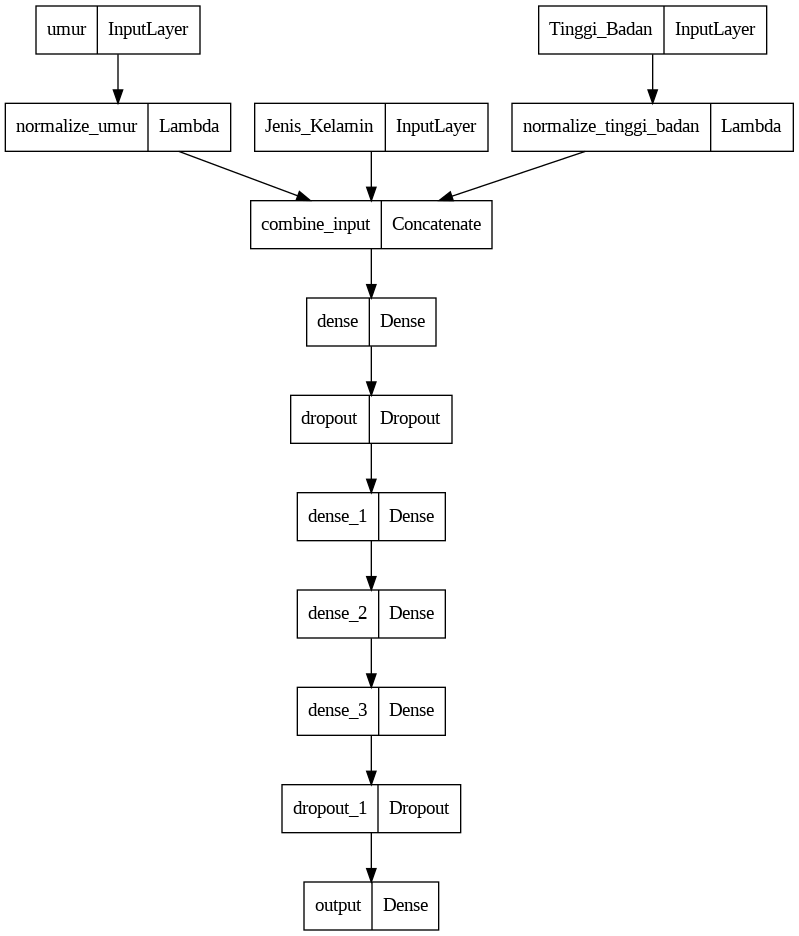

In [24]:
plot_model(model, to_file='model.png')

Model train

In [30]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=150,
          class_weight = class_weights
          )

Epoch 1/150
118/118 [==============================] - 3s 10ms/step - loss: 2.0191 - acc: 0.6628 - val_loss: 0.9306 - val_acc: 0.7385
Epoch 2/150
118/118 [==============================] - 1s 8ms/step - loss: 1.1927 - acc: 0.7961 - val_loss: 0.6740 - val_acc: 0.8505
Epoch 3/150
118/118 [==============================] - 2s 13ms/step - loss: 1.0979 - acc: 0.8104 - val_loss: 0.6995 - val_acc: 0.8232
Epoch 4/150
118/118 [==============================] - 1s 9ms/step - loss: 1.0292 - acc: 0.8241 - val_loss: 0.6027 - val_acc: 0.8739
Epoch 5/150
118/118 [==============================] - 1s 8ms/step - loss: 1.0093 - acc: 0.8260 - val_loss: 0.6482 - val_acc: 0.8510
Epoch 6/150
118/118 [==============================] - 1s 8ms/step - loss: 0.9660 - acc: 0.8363 - val_loss: 0.6540 - val_acc: 0.8347
Epoch 7/150
118/118 [==============================] - 1s 8ms/step - loss: 0.9567 - acc: 0.8347 - val_loss: 0.6869 - val_acc: 0.8234
Epoch 8/150
118/118 [==============================] - 2s 14ms/step

In [31]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

16/16 [==============================] - 0s 3ms/step - loss: 0.4689 - acc: 0.8993
Accuracy 0.8993152379989624


Testing the model with user input

In [35]:
def predict_input(input_umur, input_jenis_kelamin, input_tinggi_badan):
  # Create input dictionary
  if input_jenis_kelamin == 'laki=laki':
    jenis_kelamin = 0
  else:
    jenis_kelamin = 1

  user_input = {
      'umur': np.array([input_umur], dtype=np.float32),
      'Jenis_Kelamin': np.array([jenis_kelamin], dtype=np.float32),
      'Tinggi_Badan': np.array([input_tinggi_badan], dtype=np.float32)
  }

  # Make prediction with the loaded model
  predicted_class = model.predict(user_input).argmax(axis=1)
  if predicted_class[0] == 0:
    class_ = 'normal'
  elif predicted_class[0] == 1:
    class_ = 'tinggi'
  elif predicted_class[0] == 2:
    class_ = 'stunted'
  else:
    class_ = 'severely stunted'

  print(f'Predicted class: {class_}')

In [36]:
# Example user input
umur = 0
print(f'input umur: {umur}')
jenis_kelamin = 'laki-laki'
print(f'input jenis kelamin: {jenis_kelamin}')
tinggi_badan = 44.257719
print(f'input tinggi badan: {tinggi_badan}')

predict_input(umur, jenis_kelamin, tinggi_badan)

input umur: 0
input jenis kelamin: laki-laki
input tinggi badan: 44.257719
1/1 [==============================] - 0s 23ms/step
Predicted class: severely stunted


Save and convert model to tfjs

In [37]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 949.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
    

In [1]:
!tensorflowjs_converter --input_format=keras model.h5 /content/tfjs_model

2024-06-11 09:49:47.878770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 09:49:50.742004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!zip -r /content/tfjs_model.zip /content/tfjs_model/*

  adding: content/tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 81%)


In [3]:
from google.colab import files
files.download("/content/tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>